In [1]:
#@title MIT License
#
# Copyright (c) 2019 Andreas Eberlein
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Predict hiking times based on statistics from GPX files

We attempt to predict the walking times (or more precisely the moving times) for hikes based on statistics extracted from GPX files. Using personal GPX records as input, the outputs are personalized as well.

The code is based on the `basic_regression.ipynb` notebook from [Tensorflow tutorials](https://github.com/tensorflow/docs/blob/r1.13/site/en/tutorials/keras/basic_regression.ipynb).

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.callbacks as callbacks

import numpy as np

import utils

print(tf.__version__)

1.13.1


### Load data
Load the dataset that was prepared by running `prepareData.py`.

In [3]:
dataset_path = 'hiking_data.csv'
dataset_path

'hiking_data.csv'

Convert data to a pandas dataframe:

In [4]:
import gpxStats

column_names = gpxStats.GpxStats.getHeader()
raw_dataset = pd.read_csv(dataset_path, header=0,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

raw_dataset.pop('Name')
raw_dataset.pop('MaxSpeed')

dataset = raw_dataset.copy()
dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill
30,5243.076831,5281.999032,4833.0,4547.0,286.0,245.8,217.8
31,19041.915231,19243.293370,25050.0,20648.0,4402.0,1126.1,420.1
32,5558.221065,5623.842801,5956.0,5652.0,304.0,145.8,333.8
33,9581.878271,9937.377262,17899.0,12789.0,5110.0,757.0,784.0
34,10254.193843,10565.320829,15016.0,11498.0,3518.0,1070.0,480.0


### Clean the data

Inspect dataset and see if there are unknown values:

In [5]:
dataset.isna().sum()

Length2d         0
Length3d         0
Duration         0
MovingTime       0
StoppedTime      0
TotalUphill      0
TotalDownhill    0
dtype: int64

The data looks fine, so we do not have to clean it.

In [6]:
# dataset = dataset.dropna()

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the data set.

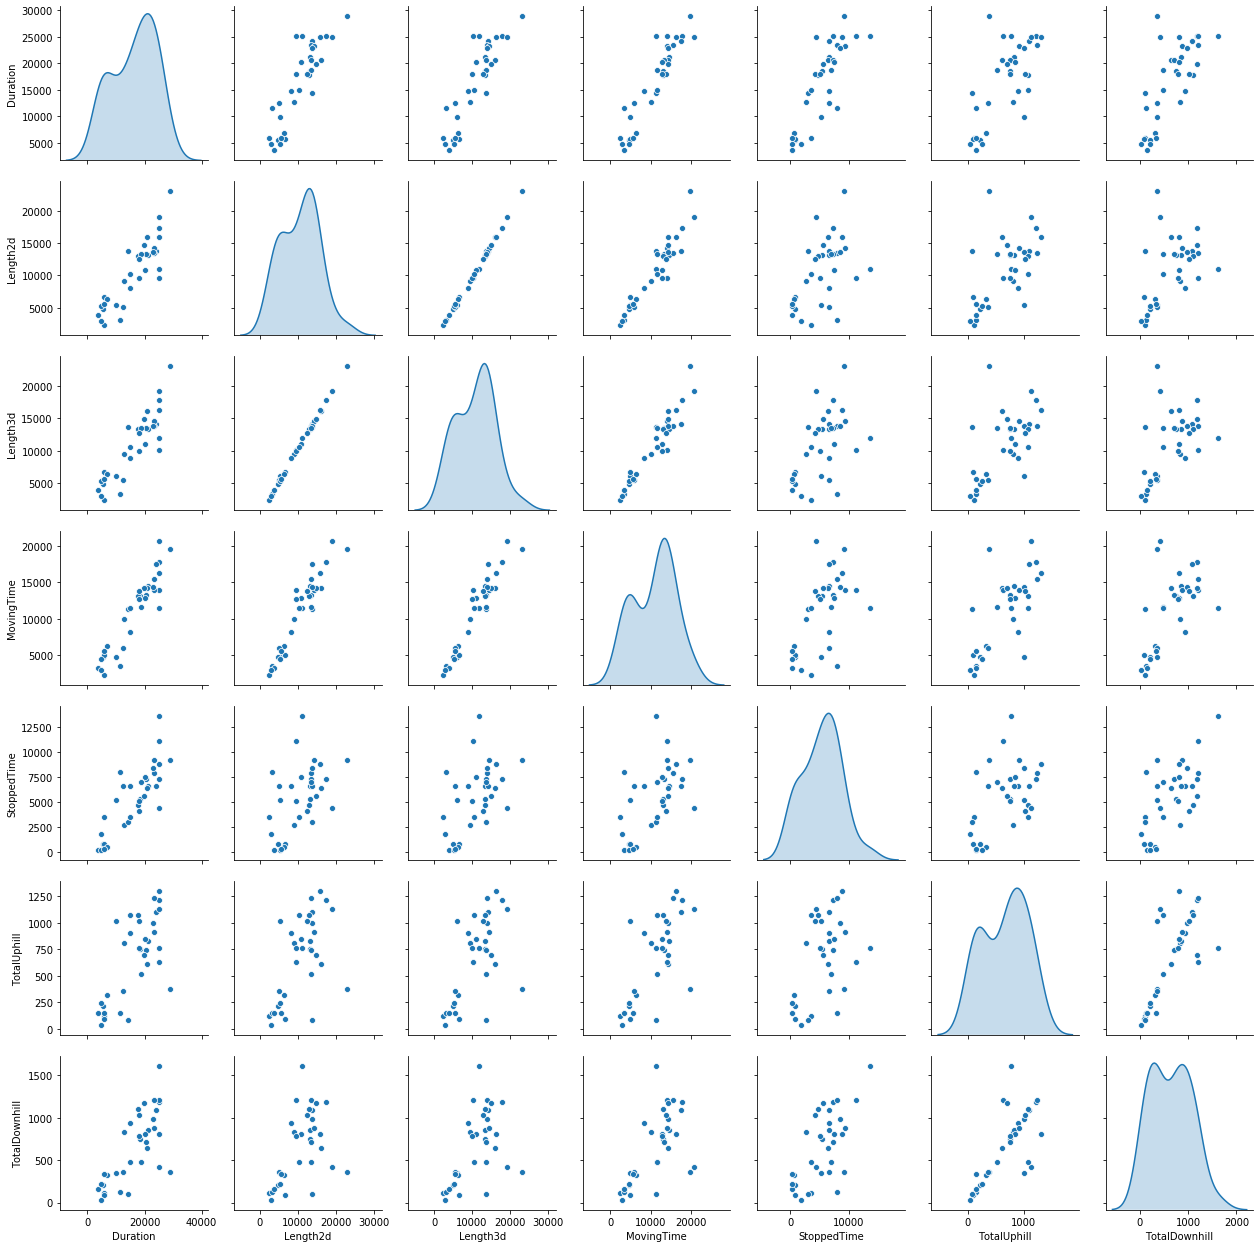

In [7]:
sns.pairplot(dataset[["Duration", "Length2d", "Length3d", "MovingTime", "StoppedTime", "TotalUphill", "TotalDownhill"]], diag_kind="kde")

Also look at the overall statistics:

In [8]:
dataset_stats = dataset.describe()
dataset_stats.pop("MovingTime")
dataset_stats.pop("StoppedTime")
dataset_stats.pop("Duration")
dataset_stats = dataset_stats.transpose()
dataset_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,35.0,10668.625231,4995.734686,2298.224548,5937.420713,11024.854803,13649.633375,22992.146694
Length3d,35.0,10924.729291,5032.621938,2335.560357,6213.562623,11944.767174,13880.278408,23064.936335
TotalUphill,35.0,661.813474,391.467674,34.819992,282.050049,748.280133,1002.489734,1299.260278
TotalDownhill,35.0,649.264986,413.664471,32.019989,328.550049,712.839954,958.289746,1612.700000


The `"Name"` column does not contain information about the walking time, so we dropped it. `"MaxSpeed"` does not contain useful information for our purpose, and seems to be uncorrelated with `"MovingTime"`, `"StoppedTime"` as well as `"Duration"`.

In [9]:
dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill
30,5243.076831,5281.999032,4833.0,4547.0,286.0,245.8,217.8
31,19041.915231,19243.293370,25050.0,20648.0,4402.0,1126.1,420.1
32,5558.221065,5623.842801,5956.0,5652.0,304.0,145.8,333.8
33,9581.878271,9937.377262,17899.0,12789.0,5110.0,757.0,784.0
34,10254.193843,10565.320829,15016.0,11498.0,3518.0,1070.0,480.0


### Split the data into train and test datasets

Now we split the dataset into a training set and a test set. We will use the test set in the final evaluation of our model.

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Obtain statistics about the training set for normalization:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MovingTime")
train_stats.pop("StoppedTime")
train_stats.pop("Duration")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,28.0,10213.211641,5318.329028,2298.224548,5377.981800,10526.186907,13514.032898,22992.146694
Length3d,28.0,10437.984649,5374.028828,2335.560357,5590.520828,10827.067029,13876.541372,23064.936335
TotalUphill,28.0,640.071417,401.096536,34.819992,238.164987,719.699805,1012.110075,1232.459943
TotalDownhill,28.0,606.942849,402.424382,32.019989,296.925073,476.370143,994.444688,1210.659955


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [12]:
# train_dataset.pop('StoppedTime')

label_columns = ['MovingTime', 'StoppedTime', 'Duration']
train_labels_data = []
test_labels_data = []

for col_name in label_columns:
    train_labels_data.append(train_dataset.pop(col_name))
    test_labels_data.append(test_dataset.pop(col_name))

train_labels = pd.concat(train_labels_data, axis=1)
train_labels.sort_index(inplace=True)
test_labels = pd.concat(test_labels_data, axis=1)
test_labels.sort_index(inplace=True)

train_dataset.sort_index(inplace=True)

In [13]:
print(train_dataset.tail())
print(train_labels.tail())

        Length2d      Length3d  TotalUphill  TotalDownhill
29  12515.753003  12810.416737  1017.240302    1025.840277
30   5243.076831   5281.999032   245.800000     217.800000
31  19041.915231  19243.293370  1126.100000     420.100000
32   5558.221065   5623.842801   145.800000     333.800000
34  10254.193843  10565.320829  1070.000000     480.000000
    MovingTime  StoppedTime  Duration
29     13817.0       4166.0   17983.0
30      4547.0        286.0    4833.0
31     20648.0       4402.0   25050.0
32      5652.0        304.0    5956.0
34     11498.0       3518.0   15016.0


### Normalize the data

The statistics about `train_stats` in the above block shows a wide variation of ranges for all features. Although a model *might* converge without feature normalization, the latter usually improves convergence properties.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset and the pretraining data set. We need to do that to project the test dataset into the same distribution as the one the model has been trained on.

In [14]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

with open('train_stats.csv', 'w') as csvfile:
    train_stats.to_csv(csvfile, sep=' ')

`normed_train_data` is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model. This includes the test dataset as well as input during inference. Thus we need to save the normalization numbers together with the model.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, for convencience.

In [15]:
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(len(train_labels.keys()))
    ])

    optimizer = tf.keras.optimizers.RMSprop()

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


How did we specify the architecture of the model?

The architecture is chosen such that we can reproduce esimates for walking times from a standard formula that is implemented in the function `compute_standard_walking_time` in `utils.py`. 

In principle, we would not need pretraining. However, as our set of GPX tracks from hiking is quite small, pretraining is helpful for designing the model and for making training more smooth.

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `4` examples from the training data and call `model.predict` on it.

In [17]:
example_batch = normed_train_data[:4]
example_result = model.predict(example_batch)
example_result

array([[ 0.03205552,  0.19368522, -0.13473378],
       [ 0.01090639, -0.02758918,  0.02087457],
       [-0.05304439, -0.18529162, -0.05228721],
       [ 0.14108574,  0.3335993 , -0.15936948]], dtype=float32)

## Some helper functions used later during training

In [18]:
# Plot the dependency of errors on epoch
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MovingTime]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.yscale('log')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MovingTime^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Train the model

Train the model for 1000 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [19]:
EPOCHS = 200

def learning_rate_schedule(epoch):
    return 0.01 / 3**(epoch // 50)

lr_schedule = callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)

history = model.fit(normed_train_data.values, train_labels.values,
                    epochs=EPOCHS, validation_split = 0.15, verbose=1,
                    callbacks=[lr_schedule])

Train on 23 samples, validate on 5 samples
Instructions for updating:
Use tf.cast instead.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/200
23/23 [==============================] - 0s 17ms/sample - loss: 164446000.0000 - mean_absolute_error: 10664.5479 - mean_squared_error: 164446000.0000 - val_loss: 139094480.0000 - val_mean_absolute_error: 9177.8809 - val_mean_squared_error: 139094480.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/200
23/23 [==============================] - 0s 269us/sample - loss: 164435152.0000 - mean_absolute_error: 10664.0215 - mean_squared_error: 164435152.0000 - val_loss: 139062784.0000 - val_mean_absolute_error: 9176.4072 - val_mean_squared_error: 139062784.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/200
23/23 [==============================] - 0s 480us/sample - loss: 164400128.0000 - mean_absolute_error: 10662.5078 - mean_squared_error: 164400128.0000 - val_l


Epoch 00025: LearningRateScheduler reducing learning rate to 0.01.
Epoch 25/200
23/23 [==============================] - 0s 625us/sample - loss: 22284694.0000 - mean_absolute_error: 3660.4834 - mean_squared_error: 22284694.0000 - val_loss: 12102242.0000 - val_mean_absolute_error: 2645.8909 - val_mean_squared_error: 12102242.0000

Epoch 00026: LearningRateScheduler reducing learning rate to 0.01.
Epoch 26/200
23/23 [==============================] - 0s 497us/sample - loss: 20505442.0000 - mean_absolute_error: 3541.5002 - mean_squared_error: 20505442.0000 - val_loss: 10830899.0000 - val_mean_absolute_error: 2460.5173 - val_mean_squared_error: 10830899.0000

Epoch 00027: LearningRateScheduler reducing learning rate to 0.01.
Epoch 27/200
23/23 [==============================] - 0s 588us/sample - loss: 19165940.0000 - mean_absolute_error: 3433.6733 - mean_squared_error: 19165940.0000 - val_loss: 9837022.0000 - val_mean_absolute_error: 2299.8401 - val_mean_squared_error: 9837022.0000

Epoch


Epoch 00050: LearningRateScheduler reducing learning rate to 0.01.
Epoch 50/200
23/23 [==============================] - 0s 255us/sample - loss: 9171530.0000 - mean_absolute_error: 2425.6924 - mean_squared_error: 9171530.0000 - val_loss: 5363964.0000 - val_mean_absolute_error: 1945.4840 - val_mean_squared_error: 5363964.0000

Epoch 00051: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 51/200
23/23 [==============================] - 0s 238us/sample - loss: 8899467.0000 - mean_absolute_error: 2392.1179 - mean_squared_error: 8899467.0000 - val_loss: 5355852.5000 - val_mean_absolute_error: 1945.6873 - val_mean_squared_error: 5355852.5000

Epoch 00052: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 52/200
23/23 [==============================] - 0s 319us/sample - loss: 8811949.0000 - mean_absolute_error: 2381.5503 - mean_squared_error: 8811949.0000 - val_loss: 5350165.5000 - val_mean_absolute_error: 1947.0576 - val_mean_squared_er


Epoch 00074: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 74/200
23/23 [==============================] - 0s 505us/sample - loss: 7063067.0000 - mean_absolute_error: 2163.2778 - mean_squared_error: 7063067.0000 - val_loss: 5177174.5000 - val_mean_absolute_error: 1950.7688 - val_mean_squared_error: 5177174.5000

Epoch 00075: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 75/200
23/23 [==============================] - 0s 472us/sample - loss: 6995973.5000 - mean_absolute_error: 2153.3865 - mean_squared_error: 6995973.5000 - val_loss: 5161423.0000 - val_mean_absolute_error: 1946.3164 - val_mean_squared_error: 5161423.0000

Epoch 00076: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 76/200
23/23 [==============================] - 0s 533us/sample - loss: 6930051.0000 - mean_absolute_error: 2144.0366 - mean_squared_error: 6930051.0000 - val_loss: 5164367.5000 - val_mean_absolute_error: 1948.9222 - va


Epoch 00098: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 98/200
23/23 [==============================] - 0s 275us/sample - loss: 5770261.0000 - mean_absolute_error: 1953.1240 - mean_squared_error: 5770261.0000 - val_loss: 5230500.0000 - val_mean_absolute_error: 1955.3293 - val_mean_squared_error: 5230500.0000

Epoch 00099: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 99/200
23/23 [==============================] - 0s 263us/sample - loss: 5739875.5000 - mean_absolute_error: 1938.2118 - mean_squared_error: 5739875.5000 - val_loss: 4829637.0000 - val_mean_absolute_error: 1820.7976 - val_mean_squared_error: 4829637.0000

Epoch 00100: LearningRateScheduler reducing learning rate to 0.0033333333333333335.
Epoch 100/200
23/23 [==============================] - 0s 278us/sample - loss: 5711849.0000 - mean_absolute_error: 1941.9353 - mean_squared_error: 5711849.0000 - val_loss: 5236636.5000 - val_mean_absolute_error: 1954.3168 - v


Epoch 00122: LearningRateScheduler reducing learning rate to 0.0011111111111111111.
Epoch 122/200
23/23 [==============================] - 0s 292us/sample - loss: 5315212.0000 - mean_absolute_error: 1856.5482 - mean_squared_error: 5315212.0000 - val_loss: 4975493.5000 - val_mean_absolute_error: 1859.3756 - val_mean_squared_error: 4975493.5000

Epoch 00123: LearningRateScheduler reducing learning rate to 0.0011111111111111111.
Epoch 123/200
23/23 [==============================] - 0s 243us/sample - loss: 5300719.5000 - mean_absolute_error: 1853.5278 - mean_squared_error: 5300719.5000 - val_loss: 4976142.0000 - val_mean_absolute_error: 1858.9226 - val_mean_squared_error: 4976142.0000

Epoch 00124: LearningRateScheduler reducing learning rate to 0.0011111111111111111.
Epoch 124/200
23/23 [==============================] - 0s 244us/sample - loss: 5286515.0000 - mean_absolute_error: 1850.2415 - mean_squared_error: 5286515.0000 - val_loss: 4976251.5000 - val_mean_absolute_error: 1857.2076 -


Epoch 00146: LearningRateScheduler reducing learning rate to 0.0011111111111111111.
Epoch 146/200
23/23 [==============================] - 0s 200us/sample - loss: 4987545.0000 - mean_absolute_error: 1786.8177 - mean_squared_error: 4987545.0000 - val_loss: 4962222.5000 - val_mean_absolute_error: 1826.4573 - val_mean_squared_error: 4962222.5000

Epoch 00147: LearningRateScheduler reducing learning rate to 0.0011111111111111111.
Epoch 147/200
23/23 [==============================] - 0s 549us/sample - loss: 4976064.5000 - mean_absolute_error: 1785.4263 - mean_squared_error: 4976064.5000 - val_loss: 5018999.0000 - val_mean_absolute_error: 1845.4808 - val_mean_squared_error: 5018999.0000

Epoch 00148: LearningRateScheduler reducing learning rate to 0.0011111111111111111.
Epoch 148/200
23/23 [==============================] - 0s 526us/sample - loss: 4965185.5000 - mean_absolute_error: 1782.4705 - mean_squared_error: 4965185.5000 - val_loss: 4953853.0000 - val_mean_absolute_error: 1826.6731 -


Epoch 00170: LearningRateScheduler reducing learning rate to 0.00037037037037037035.
Epoch 170/200
23/23 [==============================] - 0s 573us/sample - loss: 4855089.5000 - mean_absolute_error: 1756.9918 - mean_squared_error: 4855089.5000 - val_loss: 5001356.5000 - val_mean_absolute_error: 1836.8069 - val_mean_squared_error: 5001356.5000

Epoch 00171: LearningRateScheduler reducing learning rate to 0.00037037037037037035.
Epoch 171/200
23/23 [==============================] - 0s 677us/sample - loss: 4851157.5000 - mean_absolute_error: 1756.1429 - mean_squared_error: 4851157.5000 - val_loss: 5003268.0000 - val_mean_absolute_error: 1837.5020 - val_mean_squared_error: 5003268.0000

Epoch 00172: LearningRateScheduler reducing learning rate to 0.00037037037037037035.
Epoch 172/200
23/23 [==============================] - 0s 529us/sample - loss: 4846843.0000 - mean_absolute_error: 1755.3438 - mean_squared_error: 4846843.0000 - val_loss: 5003941.0000 - val_mean_absolute_error: 1837.684


Epoch 00194: LearningRateScheduler reducing learning rate to 0.00037037037037037035.
Epoch 194/200
23/23 [==============================] - 0s 500us/sample - loss: 4759017.5000 - mean_absolute_error: 1736.0078 - mean_squared_error: 4759017.5000 - val_loss: 5036016.0000 - val_mean_absolute_error: 1847.0312 - val_mean_squared_error: 5036016.0000

Epoch 00195: LearningRateScheduler reducing learning rate to 0.00037037037037037035.
Epoch 195/200
23/23 [==============================] - 0s 288us/sample - loss: 4755415.5000 - mean_absolute_error: 1736.2786 - mean_squared_error: 4755415.5000 - val_loss: 5024013.5000 - val_mean_absolute_error: 1846.0730 - val_mean_squared_error: 5024013.5000

Epoch 00196: LearningRateScheduler reducing learning rate to 0.00037037037037037035.
Epoch 196/200
23/23 [==============================] - 0s 309us/sample - loss: 4752033.5000 - mean_absolute_error: 1734.2139 - mean_squared_error: 4752033.5000 - val_loss: 5042723.0000 - val_mean_absolute_error: 1848.602

Visualize the model's training progress using the stats stored in the `history` object.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr,epoch
195,4752033.5,1734.213867,4752033.5,5042723.0,1848.602905,5042723.0,0.00037,195
196,4748578.5,1735.125366,4748578.5,5022276.0,1846.000244,5022276.0,0.00037,196
197,4745257.5,1732.415771,4745257.5,5047520.5,1849.610107,5047520.5,0.00037,197
198,4741948.0,1733.970825,4741948.0,5024141.5,1846.951782,5024141.5,0.00037,198
199,4738560.5,1730.802368,4738560.5,5051145.5,1850.431641,5051145.5,0.00037,199


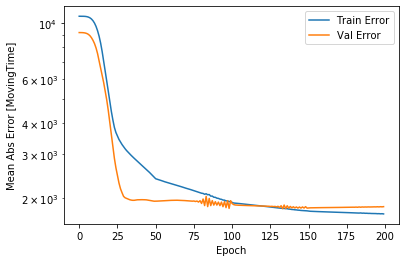

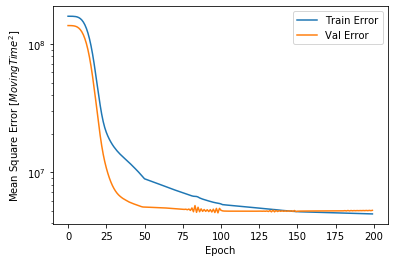

In [21]:
plot_history(history)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results.


### Make predictions

Finally, predict walking time values using data in the testing set:

In [22]:
standard_estimate = []

for index, data in test_dataset.iterrows():
    standard_estimate.append(utils.compute_standard_walking_time(data['Length2d'],
                                                                 data['TotalUphill'],
                                                                 data['TotalDownhill']))
    
moving_stopped_duration_data_list = []
for index, data in test_labels.iterrows():
    moving_stopped_duration_data_list.append([data['MovingTime'], data['StoppedTime'], data['Duration']])
moving_stopped_duration_data = np.array(moving_stopped_duration_data_list)
moving_stopped_duration_data = np.transpose(moving_stopped_duration_data)


test_predictions = model.predict(normed_test_data)
test_predictions = np.transpose(test_predictions)

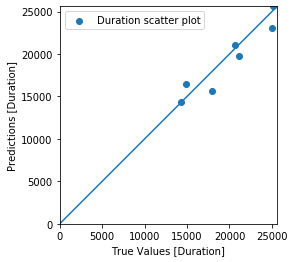

In [23]:
plt.scatter(moving_stopped_duration_data[2], test_predictions[2], label='Duration scatter plot')
max_val = max([max(moving_stopped_duration_data[2]), max(test_predictions[2])])
plt.xlabel('True Values [Duration]')
plt.ylabel('Predictions [Duration]')
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.xlim([0, max_val])
plt.ylim([0, max_val])
_ = plt.plot([0, max_val], [0, max_val])

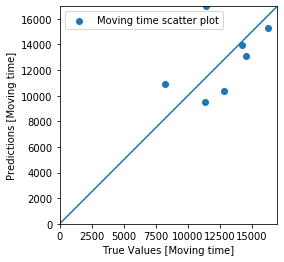

In [24]:
plt.scatter(moving_stopped_duration_data[0], test_predictions[0], label='Moving time scatter plot')
max_val = max([max(moving_stopped_duration_data[0]), max(test_predictions[0])])
plt.xlabel('True Values [Moving time]')
plt.ylabel('Predictions [Moving time]')
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.xlim([0, max_val])
plt.ylim([0, max_val])
_ = plt.plot([0, max_val], [0, max_val])

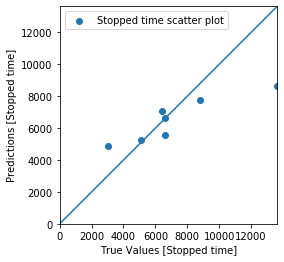

In [25]:
plt.scatter(moving_stopped_duration_data[1], test_predictions[1], label='Stopped time scatter plot')
max_val = max([max(moving_stopped_duration_data[1]), max(test_predictions[1])])
plt.xlabel('True Values [Stopped time]')
plt.ylabel('Predictions [Stopped time]')
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.xlim([0, max_val])
plt.ylim([0, max_val])
_ = plt.plot([0, max_val], [0, max_val])

It looks like our model predicts reasonably well, as the results should be as close to the diagonal as possible. Let's take a look at the error distribution.

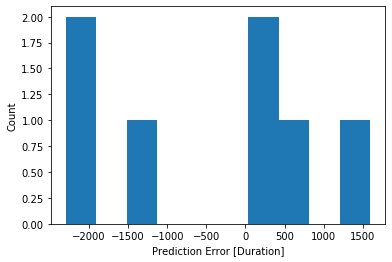

In [26]:
error = test_predictions[2] - np.transpose(np.array(test_labels))[2]
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [Duration]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

If our model yielded a reasonable training, validation and testing performance, we can export it here for future use:

In [27]:
model.save('model_hikingTimePrediction.h5')

## Conclusion

This notebook presents the training of an algorithm for predicting moving and stopping times as well as total duration for hiking (but it can also be applied to many other outdoor activities). We accomplished this by treating it as a regression problem.